# Predicting Diamond Prices

### Data Set Information:

**A dataset containing the prices and other features of almost 54,000 diamonds.**

### Features description

**Number of Attributes: 10 (9 predictive features, 1 target)**

Feature Information: A data frame with 53,940 rows and 10 variables:

price: price in US dollars (\$326--\$18,823) **(target)**

carat: weight of the diamond (0.2--5.01)

cut: quality of the cut (Fair, Good, Very Good, Premium, Ideal)

color: diamond colour, from J (worst) to D (best)

clarity: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

x: length in mm (0--10.74)

y: width in mm (0--58.9)

z: depth in mm (0--31.8)

depth: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)

table: width of top of diamond relative to widest point (43--95)

In [1]:
# Importing useful libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import OrderedDict
%matplotlib inline

## 0. Data Preparation

In [2]:
# importing data
data_path= 'diamonds.csv'
diamonds = pd.read_csv(data_path)

In [3]:
diamonds.head()

Unnamed: 0  carat      cut color clarity  depth  table  price     x     y  \
0           1   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98   
1           2   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84   
2           3   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07   
3           4   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23   
4           5   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35   

      z  
0  2.43  
1  2.31  
2  2.31  
3  2.63  
4  2.75

In [4]:
diamonds.shape

(53940, 11)

In [5]:
diamonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
Unnamed: 0    53940 non-null int64
carat         53940 non-null float64
cut           53940 non-null object
color         53940 non-null object
clarity       53940 non-null object
depth         53940 non-null float64
table         53940 non-null float64
price         53940 non-null int64
x             53940 non-null float64
y             53940 non-null float64
z             53940 non-null float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


One of the transformations we must perform is to tranform the categorical features to the one-hot-encoding format.

In [6]:
print(diamonds['cut'].unique())
print(diamonds['color'].unique())
print(diamonds['clarity'].unique())

['Ideal' 'Premium' 'Good' 'Very Good' 'Fair']
['E' 'I' 'J' 'H' 'F' 'G' 'D']
['SI2' 'SI1' 'VS1' 'VS2' 'VVS2' 'VVS1' 'I1' 'IF']


In [7]:
diamonds['cut'].head()

0      Ideal
1    Premium
2       Good
3    Premium
4       Good
Name: cut, dtype: object

In [8]:
diamonds = pd.concat([diamonds, pd.get_dummies(diamonds['cut'], prefix='cut', drop_first=True)],axis=1)
diamonds = pd.concat([diamonds, pd.get_dummies(diamonds['color'], prefix='color', drop_first=True)],axis=1)
diamonds = pd.concat([diamonds, pd.get_dummies(diamonds['clarity'], prefix='clarity', drop_first=True)],axis=1)
diamonds.drop(['cut','color','clarity'], axis=1, inplace=True)

In [9]:
diamonds.head()

Unnamed: 0  carat  depth  table  price     x     y     z  cut_Good  \
0           1   0.23   61.5   55.0    326  3.95  3.98  2.43         0   
1           2   0.21   59.8   61.0    326  3.89  3.84  2.31         0   
2           3   0.23   56.9   65.0    327  4.05  4.07  2.31         1   
3           4   0.29   62.4   58.0    334  4.20  4.23  2.63         0   
4           5   0.31   63.3   58.0    335  4.34  4.35  2.75         1   

   cut_Ideal      ...       color_H  color_I  color_J  clarity_IF  \
0          1      ...             0        0        0           0   
1          0      ...             0        0        0           0   
2          0      ...             0        0        0           0   
3          0      ...             0        1        0           0   
4          0      ...             0        0        1           0   

   clarity_SI1  clarity_SI2  clarity_VS1  clarity_VS2  clarity_VVS1  \
0            0            1            0            0             0   
1            1            0            0            0             0   
2            0            0            1            0             0   
3            0            0            0            1             0   
4            0            1            0            0             0   

   clarity_VVS2  
0             0  
1             0  
2             0  
3             0  
4             0  

[5 rows x 25 columns]

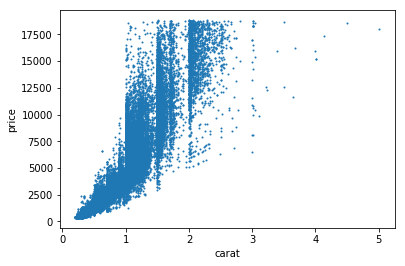

In [10]:
diamonds.plot.scatter(x='carat', y='price', s=1);

In [11]:
# To account for the non-linearity let's calculate the square of carat
diamonds['carat_squared'] = diamonds['carat']**2

### Scaling: an important operation

Since the features have different scales (<code>carat</code> goes from 0 to 5, <code>y</code> goes from 0 to 58) we need to be careful. Making sure that each feature has approximately the same scale can be a crucial preprocessing step. In this case we will use the <code>RobustScaler</code> object which scales the features to a common scale and it is robust to outliers.

### Getting the train and test sets

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler

In [13]:
target_name = 'price'
robust_scaler = RobustScaler()
X = diamonds.drop('price', axis=1)
X = robust_scaler.fit_transform(X)
y = diamonds[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

### Preparing a DataFrame for model analysis

In [14]:
models = pd.DataFrame(index=['train_mse', 'test_mse'], 
                      columns=['NULL', 'MLR', 'KNN', 'LASSO'])

## The Null model: always predict the average of the target

In [15]:
y_pred_null = y_train.mean()
models.loc['train_mse','NULL'] = mean_squared_error(y_pred=np.repeat(y_pred_null, y_train.size), 
                                                    y_true=y_train)
models.loc['test_mse','NULL'] = mean_squared_error(y_pred=np.repeat(y_pred_null, y_test.size), 
                                                   y_true=y_test)

## A. Multiple Linear Regression

In [25]:
# 1. Import the estimator object (model)
from sklearn.linear_model import LinearRegression
# 2. Create an instance of the estimator
linear_regression = LinearRegression()
# 3. Use the trainning data to train the estimator
linear_regression.fit(X_train, y_train)
# 4. Evaluate the model
models.loc['train_mse','MLR'] = mean_squared_error(y_pred=linear_regression.predict(X_train), 
                                                    y_true=y_train)

models.loc['test_mse','MLR'] = mean_squared_error(y_pred=linear_regression.predict(X_test), 
                                                   y_true=y_test)
print(mean_squared_error(y_pred=linear_regression.predict(X_test), 
                                                   y_true=y_test))

1230877.6426


## B. K-Nearest Neighbors Model

In [28]:
# 1. Import the estimator object (model)
from sklearn.neighbors import KNeighborsRegressor
# 2. Create an instance of the estimator
knn = KNeighborsRegressor(n_neighbors=10, weights='distance', metric='euclidean', n_jobs=-1)
# 3. Use the trainning data to train the estimator
knn.fit(X_train, y_train)
# 4. Evaluate the model
models.loc['train_mse','KNN'] = mean_squared_error(y_pred=knn.predict(X_train), 
                                                    y_true=y_train)

models.loc['test_mse','KNN'] = mean_squared_error(y_pred=knn.predict(X_test), 
                                                   y_true=y_test)
print( mean_squared_error(y_pred=knn.predict(X_test), 
                                                   y_true=y_test))

494981.849406


## C. Lasso

In [18]:
# 1. Import the estimator object (model)
from sklearn.linear_model import Lasso
# 2. Create an instance of the estimator
lasso = Lasso(alpha=0.1)
# 3. Use the trainning data to train the estimator
lasso.fit(X_train, y_train)
# 4. Evaluate the model
models.loc['train_mse','LASSO'] = mean_squared_error(y_pred=lasso.predict(X_train), 
                                                    y_true=y_train)

models.loc['test_mse','LASSO'] = mean_squared_error(y_pred=lasso.predict(X_test), 
                                                   y_true=y_test)

C:\Users\Chinmay\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [19]:
models

NULL          MLR     KNN        LASSO
train_mse  1.59239e+07  1.23746e+06       0  1.23752e+06
test_mse   1.58811e+07  1.23088e+06  494982  1.23154e+06

In [20]:
fig, ax = plt.subplots(figsize=(8,5))
models.loc['test_mse'].plot(kind='barh', ax=ax)
ax.set_title('Test MSE for Regression Models')
ax.legend(loc=8, ncol=4);

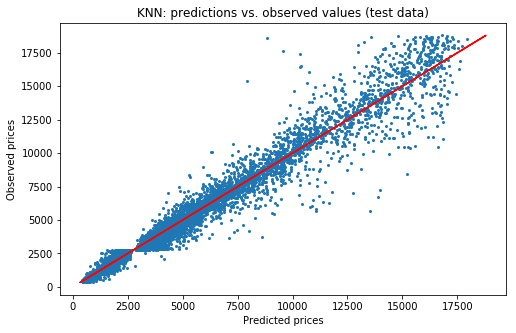

In [21]:
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(knn.predict(X_test), y_test, s=4)
ax.plot(y_test, y_test, color='red')
ax.set_title('KNN: predictions vs. observed values (test data)')
ax.set_xlabel('Predicted prices')
ax.set_ylabel('Observed prices');

## Using the best model to predict the price of a diamond

If you are happy with your model we can re-train it using all observations, and then use it to make predictions.

In [22]:
# Re-training with all the observations
knn_final = KNeighborsRegressor(n_neighbors=10, weights='distance', metric='euclidean', n_jobs=-1)
# 3. Use the trainning data to train the estimator
knn_final.fit(X, y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='euclidean',
          metric_params=None, n_jobs=-1, n_neighbors=10, p=2,
          weights='distance')

In [23]:
# Making predictions
new_diamond = OrderedDict([('carat',0.45), ('depth',62.3), ('table',59.0), ('x',3.95),
                           ('y',3.92), ('z',2.45), ('cut_Good',0.0), ('cut_Ideal',0.0),
                           ('cut_Premium',1.0), ('cut_Very Good',0.0), ('color_E',0.0), 
                           ('color_F',0.0), ('color_G',1.0), ('color_H',0.0), ('color_I',0.0),
                           ('color_J',0.0), ('clarity_IF',0.0), ('clarity_SI1',0.0),
                           ('clarity_SI2',0.0), ('clarity_VS1',0.0), ('clarity_VS2',0.0),
                           ('clarity_VVS1',1.0), ('clarity_VVS2',0.0), ('carat_squared',0.0576)])

new_diamond = pd.Series(new_diamond).values.reshape(1,-1)
print(type(new_diamond))

<class 'numpy.ndarray'>


In [24]:
knn_final.predict(new_diamond)

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
C:\Users\Chinmay\Anaconda3\lib\runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
C:\Users\Chinmay\Anaconda3\lib\runpy.py in _run_code(code=<code object <module> at 0x000001EBCD150C90, fil...lib\site-packages\ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\Chinmay\Anaconda3\lib\site-packages\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\Users\Chinmay\Anaconda3\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\C...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x000001EBCD150C90, fil...lib\site-packages\ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\Chinmay\Anaconda3\lib\site-packages\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\Users\Chinmay\Anaconda3\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\C...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
C:\Users\Chinmay\Anaconda3\lib\site-packages\ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
C:\Users\Chinmay\Anaconda3\lib\site-packages\traitlets\config\application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
C:\Users\Chinmay\Anaconda3\lib\site-packages\ipykernel\kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
C:\Users\Chinmay\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
C:\Users\Chinmay\Anaconda3\lib\site-packages\tornado\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 5
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
C:\Users\Chinmay\Anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 5), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 5)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
C:\Users\Chinmay\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=5)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
C:\Users\Chinmay\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
C:\Users\Chinmay\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
C:\Users\Chinmay\Anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
C:\Users\Chinmay\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
C:\Users\Chinmay\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'knn_final.predict(new_diamond)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 1, 28, 14, 54, 35, 305235, tzinfo=tzutc()), 'msg_id': 'C276B0BEBD9C47C984B2F65F615D9756', 'msg_type': 'execute_request', 'session': 'F8690E48C6F342318D7C534B3A8E74AF', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'C276B0BEBD9C47C984B2F65F615D9756', 'msg_type': 'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'F8690E48C6F342318D7C534B3A8E74AF']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'knn_final.predict(new_diamond)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 1, 28, 14, 54, 35, 305235, tzinfo=tzutc()), 'msg_id': 'C276B0BEBD9C47C984B2F65F615D9756', 'msg_type': 'execute_request', 'session': 'F8690E48C6F342318D7C534B3A8E74AF', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'C276B0BEBD9C47C984B2F65F615D9756', 'msg_type': 'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
C:\Users\Chinmay\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'F8690E48C6F342318D7C534B3A8E74AF'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'knn_final.predict(new_diamond)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 1, 28, 14, 54, 35, 305235, tzinfo=tzutc()), 'msg_id': 'C276B0BEBD9C47C984B2F65F615D9756', 'msg_type': 'execute_request', 'session': 'F8690E48C6F342318D7C534B3A8E74AF', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'C276B0BEBD9C47C984B2F65F615D9756', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
C:\Users\Chinmay\Anaconda3\lib\site-packages\ipykernel\ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='knn_final.predict(new_diamond)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'knn_final.predict(new_diamond)'
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
C:\Users\Chinmay\Anaconda3\lib\site-packages\ipykernel\zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('knn_final.predict(new_diamond)',), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('knn_final.predict(new_diamond)',)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
C:\Users\Chinmay\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='knn_final.predict(new_diamond)', store_history=True, silent=False, shell_futures=True)
   2693                 self.displayhook.exec_result = result
   2694 
   2695                 # Execute the user code
   2696                 interactivity = "none" if silent else self.ast_node_interactivity
   2697                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2698                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2699                 
   2700                 self.last_execution_succeeded = not has_raised
   2701 
   2702                 # Reset this so later displayed values do not modify the

...........................................................................
C:\Users\Chinmay\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Expr object>], cell_name='<ipython-input-24-863ddbe75a81>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 1ebd67dc5f8, executio..._before_exec=None error_in_exec=None result=None>)
   2803                     return True
   2804 
   2805             for i, node in enumerate(to_run_interactive):
   2806                 mod = ast.Interactive([node])
   2807                 code = compiler(mod, cell_name, "single")
-> 2808                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x000001EBD4C7B780, file "<ipython-input-24-863ddbe75a81>", line 1>
        result = <ExecutionResult object at 1ebd67dc5f8, executio..._before_exec=None error_in_exec=None result=None>
   2809                     return True
   2810 
   2811             # Flush softspace
   2812             if softspace(sys.stdout, 0):

...........................................................................
C:\Users\Chinmay\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x000001EBD4C7B780, file "<ipython-input-24-863ddbe75a81>", line 1>, result=<ExecutionResult object at 1ebd67dc5f8, executio..._before_exec=None error_in_exec=None result=None>)
   2857         outflag = True  # happens in more places, so it's easier as default
   2858         try:
   2859             try:
   2860                 self.hooks.pre_run_code_hook()
   2861                 #rprint('Running code', repr(code_obj)) # dbg
-> 2862                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x000001EBD4C7B780, file "<ipython-input-24-863ddbe75a81>", line 1>
        self.user_global_ns = {'In': ['', "# Importing useful libraries\nimport numpy as np\n...eredDict\nget_ipython().magic('matplotlib inline')", "# importing data\ndata_path= 'diamonds.csv'\ndiamonds = pd.read_csv(data_path)", 'diamonds.head()', 'diamonds.shape', 'diamonds.info()', "print(diamonds['cut'].unique())\nprint(diamonds['...r'].unique())\nprint(diamonds['clarity'].unique())", "diamonds['cut'].head()", "diamonds = pd.concat([diamonds, pd.get_dummies(d...(['cut','color','clarity'], axis=1, inplace=True)", 'diamonds.head()', "diamonds.plot.scatter(x='carat', y='price', s=1);", "# To account for the non-linearity let's calcula...\ndiamonds['carat_squared'] = diamonds['carat']**2", 'from sklearn.model_selection import train_test_s...or\nfrom sklearn.preprocessing import RobustScaler', "target_name = 'price'\nrobust_scaler = RobustScal...test_split(X, y, test_size=0.2, random_state=123)", "models = pd.DataFrame(index=['train_mse', 'test_...         columns=['NULL', 'MLR', 'KNN', 'LASSO'])", "y_pred_null = y_train.mean()\nmodels.loc['train_m...                                   y_true=y_test)", '# 1. Import the estimator object (model)\nfrom sk...                                   y_true=y_test)', '# 1. Import the estimator object (model)\nfrom sk...                                   y_true=y_test)', '# 1. Import the estimator object (model)\nfrom sk...                                   y_true=y_test)', 'models', ...], 'KNeighborsRegressor': <class 'sklearn.neighbors.regression.KNeighborsRegressor'>, 'Lasso': <class 'sklearn.linear_model.coordinate_descent.Lasso'>, 'LinearRegression': <class 'sklearn.linear_model.base.LinearRegression'>, 'OrderedDict': <class 'collections.OrderedDict'>, 'Out': {3:    Unnamed: 0  carat      cut color clarity  dep...0  2.43  
1  2.31  
2  2.31  
3  2.63  
4  2.75  , 4: (53940, 11), 7: 0      Ideal
1    Premium
2       Good
3    Premium
4       Good
Name: cut, dtype: object, 9:    Unnamed: 0  carat  depth  table  price     x ...     0  
4             0  

[5 rows x 25 columns], 19:                   NULL          MLR     KNN     ...e   1.58811e+07  1.23088e+06  494982  1.23154e+06, 22: KNeighborsRegressor(algorithm='auto', leaf_size=..._neighbors=10, p=2,
          weights='distance')}, 'RobustScaler': <class 'sklearn.preprocessing.data.RobustScaler'>, 'X': array([[-1.        , -0.734375  , -0.2       , ....  0.        ,
         0.        ,  0.07866753]]), 'X_test': array([[ 0.21192458, -0.609375  ,  0.8       , ....  0.        ,
         0.        , -0.12792969]]), 'X_train': array([[-0.50458852, -0.71875   ,  0.73333333, ....  1.        ,
         0.        ,  0.01529948]]), ...}
        self.user_ns = {'In': ['', "# Importing useful libraries\nimport numpy as np\n...eredDict\nget_ipython().magic('matplotlib inline')", "# importing data\ndata_path= 'diamonds.csv'\ndiamonds = pd.read_csv(data_path)", 'diamonds.head()', 'diamonds.shape', 'diamonds.info()', "print(diamonds['cut'].unique())\nprint(diamonds['...r'].unique())\nprint(diamonds['clarity'].unique())", "diamonds['cut'].head()", "diamonds = pd.concat([diamonds, pd.get_dummies(d...(['cut','color','clarity'], axis=1, inplace=True)", 'diamonds.head()', "diamonds.plot.scatter(x='carat', y='price', s=1);", "# To account for the non-linearity let's calcula...\ndiamonds['carat_squared'] = diamonds['carat']**2", 'from sklearn.model_selection import train_test_s...or\nfrom sklearn.preprocessing import RobustScaler', "target_name = 'price'\nrobust_scaler = RobustScal...test_split(X, y, test_size=0.2, random_state=123)", "models = pd.DataFrame(index=['train_mse', 'test_...         columns=['NULL', 'MLR', 'KNN', 'LASSO'])", "y_pred_null = y_train.mean()\nmodels.loc['train_m...                                   y_true=y_test)", '# 1. Import the estimator object (model)\nfrom sk...                                   y_true=y_test)', '# 1. Import the estimator object (model)\nfrom sk...                                   y_true=y_test)', '# 1. Import the estimator object (model)\nfrom sk...                                   y_true=y_test)', 'models', ...], 'KNeighborsRegressor': <class 'sklearn.neighbors.regression.KNeighborsRegressor'>, 'Lasso': <class 'sklearn.linear_model.coordinate_descent.Lasso'>, 'LinearRegression': <class 'sklearn.linear_model.base.LinearRegression'>, 'OrderedDict': <class 'collections.OrderedDict'>, 'Out': {3:    Unnamed: 0  carat      cut color clarity  dep...0  2.43  
1  2.31  
2  2.31  
3  2.63  
4  2.75  , 4: (53940, 11), 7: 0      Ideal
1    Premium
2       Good
3    Premium
4       Good
Name: cut, dtype: object, 9:    Unnamed: 0  carat  depth  table  price     x ...     0  
4             0  

[5 rows x 25 columns], 19:                   NULL          MLR     KNN     ...e   1.58811e+07  1.23088e+06  494982  1.23154e+06, 22: KNeighborsRegressor(algorithm='auto', leaf_size=..._neighbors=10, p=2,
          weights='distance')}, 'RobustScaler': <class 'sklearn.preprocessing.data.RobustScaler'>, 'X': array([[-1.        , -0.734375  , -0.2       , ....  0.        ,
         0.        ,  0.07866753]]), 'X_test': array([[ 0.21192458, -0.609375  ,  0.8       , ....  0.        ,
         0.        , -0.12792969]]), 'X_train': array([[-0.50458852, -0.71875   ,  0.73333333, ....  1.        ,
         0.        ,  0.01529948]]), ...}
   2863             finally:
   2864                 # Reset our crash handler in place
   2865                 sys.excepthook = old_excepthook
   2866         except SystemExit as e:

...........................................................................
C:\Users\Chinmay\Desktop\MyPrediction\Code-42\Code\Section5\<ipython-input-24-863ddbe75a81> in <module>()
----> 1 knn_final.predict(new_diamond)

...........................................................................
C:\Users\Chinmay\Anaconda3\lib\site-packages\sklearn\neighbors\regression.py in predict(self=KNeighborsRegressor(algorithm='auto', leaf_size=..._neighbors=10, p=2,
          weights='distance'), X=array([[  4.50000000e-01,   6.23000000e+01,   5....000000e+00,   0.00000000e+00,   5.76000000e-02]]))
    139         y : array of int, shape = [n_samples] or [n_samples, n_outputs]
    140             Target values
    141         """
    142         X = check_array(X, accept_sparse='csr')
    143 
--> 144         neigh_dist, neigh_ind = self.kneighbors(X)
        neigh_dist = undefined
        neigh_ind = undefined
        self.kneighbors = <bound method KNeighborsMixin.kneighbors of KNei...neighbors=10, p=2,
          weights='distance')>
        X = array([[  4.50000000e-01,   6.23000000e+01,   5....000000e+00,   0.00000000e+00,   5.76000000e-02]])
    145 
    146         weights = _get_weights(neigh_dist, self.weights)
    147 
    148         _y = self._y

...........................................................................
C:\Users\Chinmay\Anaconda3\lib\site-packages\sklearn\neighbors\base.py in kneighbors(self=KNeighborsRegressor(algorithm='auto', leaf_size=..._neighbors=10, p=2,
          weights='distance'), X=array([[  4.50000000e-01,   6.23000000e+01,   5....000000e+00,   0.00000000e+00,   5.76000000e-02]]), n_neighbors=10, return_distance=True)
    380                     "%s does not work with sparse matrices. Densify the data, "
    381                     "or set algorithm='brute'" % self._fit_method)
    382             result = Parallel(n_jobs, backend='threading')(
    383                 delayed(self._tree.query, check_pickle=False)(
    384                     X[s], n_neighbors, return_distance)
--> 385                 for s in gen_even_slices(X.shape[0], n_jobs)
        X.shape = (1, 24)
        n_jobs = 4
    386             )
    387             if return_distance:
    388                 dist, neigh_ind = tuple(zip(*result))
    389                 result = np.vstack(dist), np.vstack(neigh_ind)

...........................................................................
C:\Users\Chinmay\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=4), iterable=<generator object KNeighborsMixin.kneighbors.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=4)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Sun Jan 28 20:25:03 2018
PID: 9516               Python 3.6.3: C:\Users\Chinmay\Anaconda3\python.exe
...........................................................................
C:\Users\Chinmay\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<built-in method query of sklearn.neighbors.kd_tree.KDTree object>, (array([[  4.50000000e-01,   6.23000000e+01,   5....000000e+00,   0.00000000e+00,   5.76000000e-02]]), 10, True), {})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\Chinmay\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <built-in method query of sklearn.neighbors.kd_tree.KDTree object>
        args = (array([[  4.50000000e-01,   6.23000000e+01,   5....000000e+00,   0.00000000e+00,   5.76000000e-02]]), 10, True)
        kwargs = {}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\Chinmay\Anaconda3\lib\site-packages\sklearn\neighbors\kd_tree.cp36-win_amd64.pyd in sklearn.neighbors.kd_tree.BinaryTree.query()

ValueError: query data dimension must match training data dimension
___________________________________________________________________________